# Triton


Programming for accelerators such as GPUs is critical for modern AI systems.
This often means programming directly in proprietary low-level languages such as CUDA. [Triton](https://github.com/openai/triton/) is an alternative open-source language that allows you to code at a higher-level and compile to accelerators like GPU.

Coding for Triton is very similar to Numpy and PyTorch in both syntax and semantics. However, as a lower-level language there are a lot of details that you need to keep track of. In particular, one area that learners have trouble with is memory loading and storage which is critical for speed on low-level devices.

## Part 1: Trivial Examples (60%)
 You will start with trivial examples and build your way up to real algorithms like Flash Attention and Quantized neural networks. 
 
 Problem 1 to 8 **do not** need to run on GPU.

In [1]:
import torch
import triton
from torch import Tensor
import triton.language as tl
import jaxtyping
from jaxtyping import Float32, Int32

In [2]:
# @title Setup

import triton_viz
import inspect
from triton_viz.interpreter import record_builder

def test(puzzle, puzzle_spec, nelem={}, B={"B0": 32}, viz=True):
    B = dict(B)
    if "N1" in nelem and "B1" not in B:
        B["B1"] = 32
    if "N2" in nelem and "B2" not in B:
        B["B2"] = 32

    triton_viz.interpreter.record_builder.reset()
    torch.manual_seed(0)
    signature = inspect.signature(puzzle_spec)
    args = {}
    for n, p in signature.parameters.items():
        print(p)
        args[n + "_ptr"] = ([d.size for d in p.annotation.dims], p)
    args["z_ptr"] = ([d.size for d in signature.return_annotation.dims], None)

    tt_args = []
    for k, (v, t) in args.items():
        tt_args.append(torch.rand(*v) - 0.5)
        if t is not None and t.annotation.dtypes[0] == "int32":
            tt_args[-1] = torch.randint(-100000, 100000, v)
    grid = lambda meta: (triton.cdiv(nelem["N0"], meta["B0"]),
                         triton.cdiv(nelem.get("N1", 1), meta.get("B1", 1)),
                         triton.cdiv(nelem.get("N2", 1), meta.get("B2", 1)))

    #for k, v in args.items():
    #    print(k, v)
    triton_viz.trace(puzzle)[grid](*tt_args, **B, **nelem)
    z = tt_args[-1]
    tt_args = tt_args[:-1]
    z_ = puzzle_spec(*tt_args)
    match = torch.allclose(z, z_, rtol=1e-3, atol=1e-3)
    print("Results match:",  "✅" if match else "❌", match)
    failures = False
    if viz:
        failures = triton_viz.launch()
    if not match or failures:
        print("Invalid Access:", failures)
        print("Yours:", z)
        print("Spec:", z_)
        print(torch.isclose(z, z_))
        return


/home/johnlol/EAI/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Introduction

To begin with, we will only use `tl.load` and `tl.store` in order to build simple programs.

Here's an example of load. It takes an `arange` over the memory. By default the indexing of torch tensors with column, rows, depths or right-to-left. It also takes in a mask as the second argument. Mask is critically important because all shapes in Triton need to be powers of two.

In [3]:
@triton.jit                             #  JIT compiled for GPU
def demo(x_ptr):
    range = tl.arange(0, 8)             # return 0 to 7, the kernel is only trying to access  8 elements from memory
    # print works in the interpreter
    print(range)
    x = tl.load(x_ptr + range, range < 5, 0)    # returns a tensor whose value is loaded from memory defined by the pointer, only loads values from addr where the masks is true
    print(x)

triton_viz.trace(demo)[(1, 1, 1)](torch.ones(4, 3))         # trace the execution of a function, (1, 1, 1) specifies a particular grid configuration for Triton kernel
triton_viz.launch()                                         # kernels are launched with a specific grid size, the tuple represents a 3D grid with 1 block in each dimension

[0 1 2 3 4 5 6 7]
[1. 1. 1. 1. 1. 0. 0. 0.]
* Running on public URL: https://e72d5ee46cbbc08d64.gradio.live


{}

You can also use this trick to read in a 2d array.

In [4]:
@triton.jit
def demo(x_ptr):
    i_range = tl.arange(0, 8)[:, None]
    j_range = tl.arange(0, 4)[None, :]
    range = i_range * 4 + j_range
    # print works in the interpreter
    print(range)
    x = tl.load(x_ptr + range, (i_range < 4) & (j_range < 3), 0)
    print(x)

triton_viz.trace(demo)[(1, 1, 1)](torch.ones(4, 4))
triton_viz.launch()

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]]
[[1. 1. 1. 0.]
 [1. 1. 1. 0.]
 [1. 1. 1. 0.]
 [1. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
* Running on public URL: https://f97191ec1c30b61356.gradio.live


{}

The `tl.store` function is quite similar. It allows you to write to a tensor.

In [5]:
@triton.jit
def demo(z_ptr):
    range = tl.arange(0, 8)
    z = tl.store(z_ptr + range, 10, range < 5)      # write value 10 to the first 5 positions of the memory, z_ptr points to the address of torch tensor 

z = torch.ones(4, 3)
triton_viz.trace(demo)[(1, 1, 1)](z)
print(z)
triton_viz.launch()

tensor([[10., 10., 10.],
        [10., 10.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]])
* Running on public URL: https://6ad8c57e8636cca8af.gradio.live


{}

You can only load in relatively small `blocks` at a time in Triton. to work with larger tensors you need to use a program id axis to run multiple blocks in parallel. Here is an example with one program axis with 3 blocks. You can use the visualizer to scroll over it.

In [6]:
@triton.jit
def demo(x_ptr):
    pid = tl.program_id(0)                  # 3 pid values since 3 block in x dimension
    range = tl.arange(0, 8) + pid * 8
    x = tl.load(x_ptr + range, range < 20)
    print("Print for each", pid, x)

x = torch.ones(2, 4, 4)
triton_viz.trace(demo)[(3, 1, 1)](x)
triton_viz.launch()
# left shows the full input tensor structure
# right shows the memory being loaded by the kernel
# the colored region represents active memory areas being accessed

Print for each [0] [1. 1. 1. 1. 1. 1. 1. 1.]
Print for each [1] [1. 1. 1. 1. 1. 1. 1. 1.]
Print for each [2] [1. 1. 1. 1. 0. 0. 0. 0.]
* Running on public URL: https://dc59f471fa6ba1c878.gradio.live


{}

See the [Triton Docs](https://triton-lang.org/main/index.html) for further information.

## Warm up : Constant Add

Add a constant to a vector. Uses one program id axis. Block size `B0` is always the same as vector `x` with length `N0`.


$$z_i = 10 + x_i \text{ for } i = 1\ldots N_0$$


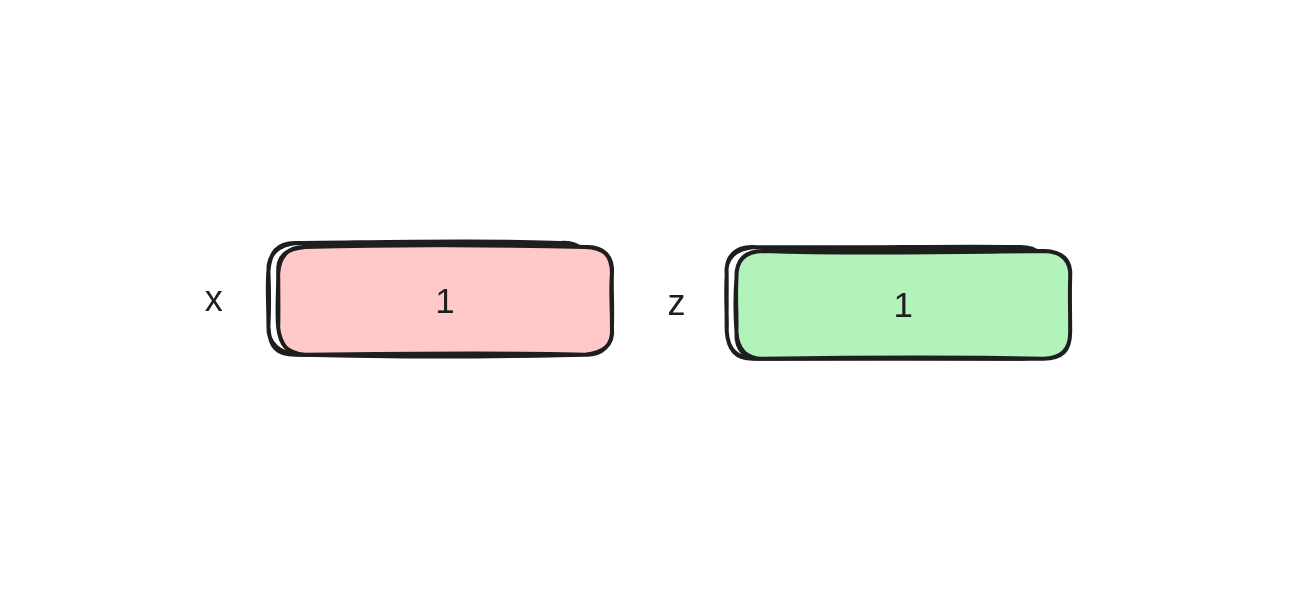

In [7]:
def add_spec(x: Float32[Tensor, "32"]) -> Float32[Tensor, "32"]:        # x is a 32 elements tensor of 32 bits floating point
    "This is the spec that you should implement. Uses typing to define sizes."
    return x + 10.

@triton.jit
def add_kernel(x_ptr, z_ptr, N0, B0: tl.constexpr):         # x_ptr pointer to the input tensor, z_ptr pointer to the output tensor
    range = tl.arange(0, B0)                                # N0 is size parameter, B0 is block size
    x = tl.load(x_ptr + range)
    tl.store(z_ptr + range, x + 10)


test(add_kernel, add_spec, nelem={"N0": 32}, viz=True)

x: jaxtyping.Float32[Tensor, '32']
Results match: ✅ True
* Running on public URL: https://1991fdb6cb11208e57.gradio.live


## Question 1 (5 pts): Constant Add Block

Add a constant to a vector. Uses one program block axis (no `for` loops yet). Block size `B0` is now smaller than the shape vector `x` which is `N0`.


$$z_i = 10 + x_i \text{ for } i = 1\ldots N_0$$



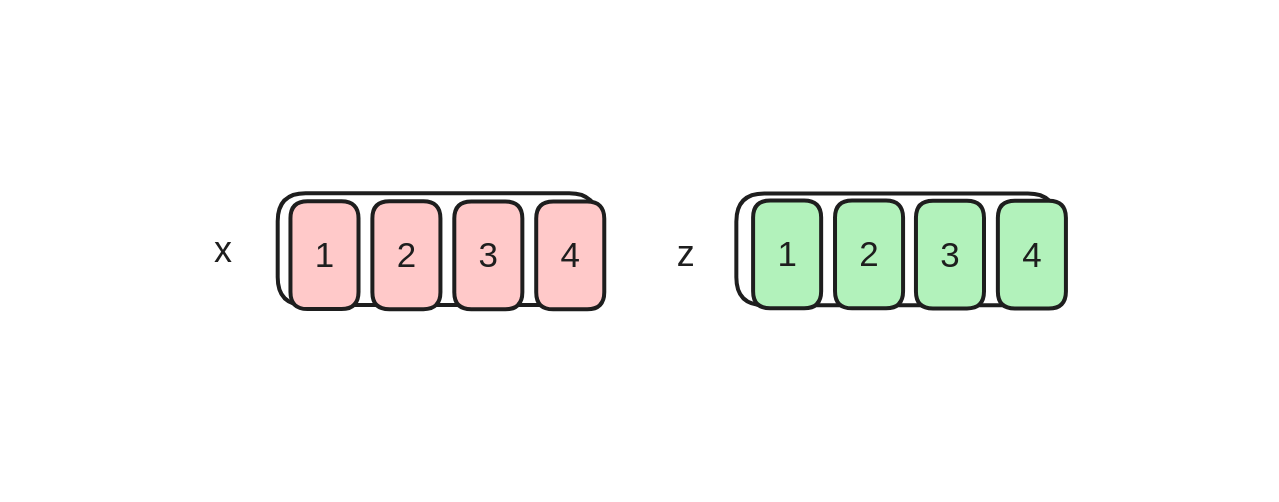

In [8]:
def add2_spec(x: Float32[Tensor, "200"]) -> Float32[Tensor, "200"]:
    return x + 10.

@triton.jit
def add_mask2_kernel(x_ptr, z_ptr, N0, B0: tl.constexpr):

    # YOUR CODE STRATS HERE

    # 1. get pid
    # In Triton, each kernel instance executes block operations on a single thread:
    # there is no construct analogous to threadIdx
    pid = tl.program_id(0)

    # 2. compute offsets
    # Note that offsets is a list of pointers:
    offset = pid * B0
    offsets = offset + tl.arange(0, B0)
    # 3. Create a mask to guard memory operations against out-of-bounds accesses.
    mask = offsets < N0         # creates a boolean mask that's True only for valid indices

    # 4. Load x from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size.
    x = tl.load(x_ptr+offsets, mask=mask)
    result = x + 10
    # 5. Write x back to DRAM. Do not forget masking .
    z = tl.store(z_ptr+offsets, result, mask=mask)

    # YOUR CODE ENDS HERE
    return

test(add_mask2_kernel, add2_spec, nelem={"N0": 200})

x: jaxtyping.Float32[Tensor, '200']
Results match: ✅ True


* Running on public URL: https://4f4b4efc737cace0f4.gradio.live


## Question 2 (5 pts): Outer Vector Add

Add two vectors.

Uses one program block axis. Block size `B0` is always the same as vector `x` length `N0`.
Block size `B1` is always the same as vector `y` length `N1`.


$$z_{j, i} = x_i + y_j\text{ for } i = 1\ldots B_0,\ j = 1\ldots B_1$$


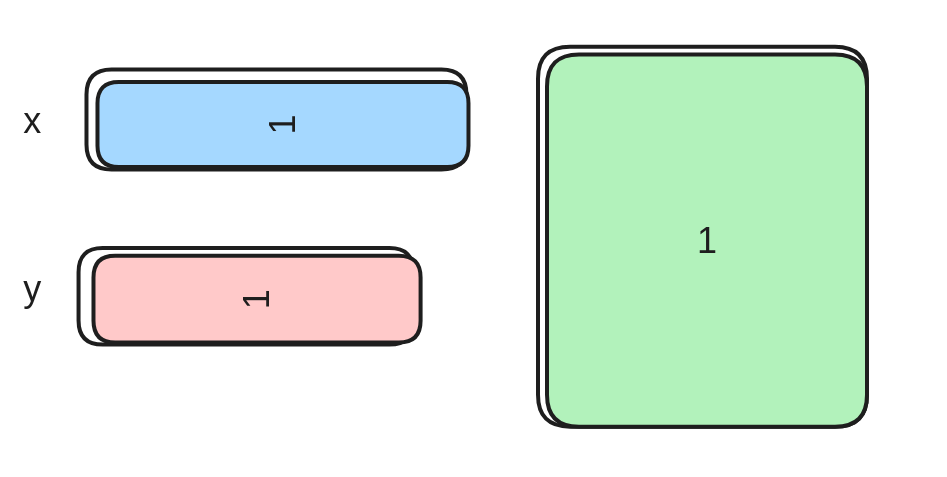

In [9]:
def add_vec_spec(x: Float32[Tensor, "32"], y: Float32[Tensor, "32"]) -> Float32[Tensor, "32 32"]:
    return x[None, :] + y[:, None]          # x: 1x32, y: 32x1

@triton.jit
def add_vec_kernel(x_ptr, y_ptr, z_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):

    # YOUR CODE STRATS HERE

    # 1. compute offsets ,in this case you will need three sets of offsets.
    offset_x = tl.arange(0, B0)
    offset_y = tl.arange(0, B1)
    # 2. load x and y from DRAM
    x = tl.load(x_ptr + offset_x)
    y = tl.load(y_ptr + offset_y)
    # 3. Compute z.
    for j in range(B1):
        y_j = tl.load(y_ptr + j)
        row_z = x + y_j
        offset_z = j * N0 + offset_x            # offset_x gives the column position
    # 4. write z back to DRAM
        tl.store(z_ptr + offset_z, row_z)

    # YOUR CODE ENDS HERE

    return

test(add_vec_kernel, add_vec_spec, nelem={"N0": 32, "N1": 32})

x: jaxtyping.Float32[Tensor, '32']
y: jaxtyping.Float32[Tensor, '32']
Results match: ✅ True
* Running on public URL: https://7701f9443928cdfe42.gradio.live


## Question 3 (5 pts): Outer Vector Add Block

Add a row vector to a column vector.

Uses two program block axes. Block size `B0` is always less than the vector `x` length `N0`.
Block size `B1` is always less than vector `y` length `N1`.

$$z_{j, i} = x_i + y_j\text{ for } i = 1\ldots N_0,\ j = 1\ldots N_1$$


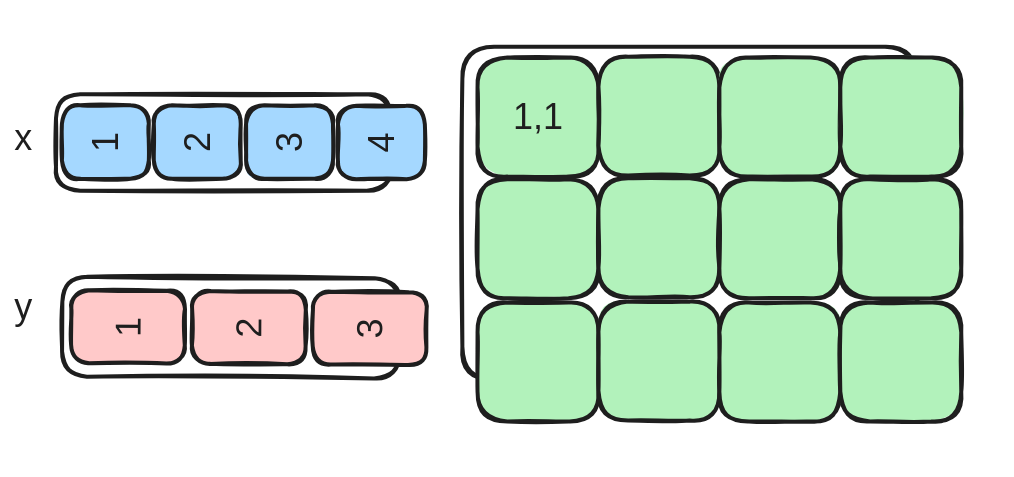

In [10]:
def add_vec_block_spec(x: Float32[Tensor, "100"], y: Float32[Tensor, "90"]) -> Float32[Tensor, "90 100"]:
    return x[None, :] + y[:, None]          # x: 1x32 , y: 32x1, N0 = 100, N1 = 90

@triton.jit
def add_vec_block_kernel(x_ptr, y_ptr, z_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):

    # The rows and columns of the addtion are independent, so we can parallelize across those
    pid_0 = tl.program_id(0)        # go through the columns (0,0) (0,1) (0,2) (1,0) (1,1) (1,2) ... (3,0) (3,1) (3,2)
    pid_1 = tl.program_id(1)
    # YOUR CODE STRATS HERE
    # 1. compute offsets ,in this case you will need three sets of offsets.
    start_x = pid_0 * B0
    start_y = pid_1 * B1
    # 2. load x and y from DRAM,masking out any extra elements in case the input is not a
    # multiple of the block size.
    offset_x = start_x + tl.arange(0, B0)
    offset_y = start_y + tl.arange(0, B1)
    mask_x = offset_x < N0
    mask_y = offset_y < N1
    x_block = tl.load(x_ptr + offset_x, mask=mask_x)
    y_block = tl.load(y_ptr + offset_y, mask=mask_y)
    # 3. compute z
    # 4. write z back to DRAM.
    for j in range(B1):
        if start_y + j < N1:
            y_j = tl.load(y_ptr + start_y + j)
            z_row = x_block + y_j
            z_row_offset = (start_y + j) * N0 + start_x         # N0 from top to down, start_x for a specific block
            tl.store(z_ptr + z_row_offset + tl.arange(0, B0), z_row, mask=mask_x)
    # YOUR CODE ENDS HERE
    return

test(add_vec_block_kernel, add_vec_block_spec, nelem={"N0": 100, "N1": 90})

x: jaxtyping.Float32[Tensor, '100']
y: jaxtyping.Float32[Tensor, '90']
Results match: ✅ True
* Running on public URL: https://a0ab46dc92a62de1a9.gradio.live


## Question 4 (5 pts): Fused Outer Multiplication

Multiply a row vector to a column vector and take a relu.

Uses two program block axes. Block size `B0` is always less than the vector `x` length `N0`.
Block size `B1` is always less than vector `y` length `N1`.

$$z_{j, i} = \text{relu}(x_i \times y_j)\text{ for } i = 1\ldots N_0,\ j = 1\ldots N_1$$



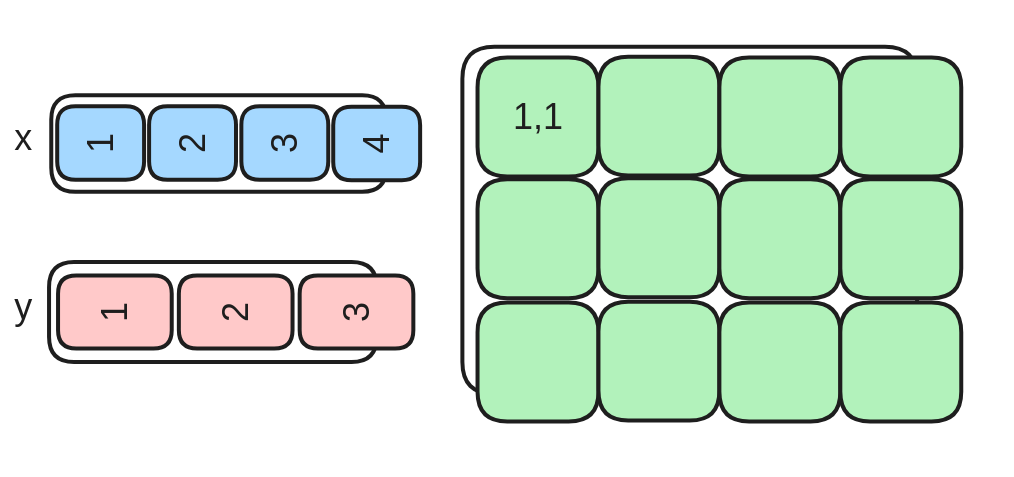

In [11]:


def mul_relu_block_spec(x: Float32[Tensor, "100"], y: Float32[Tensor, "90"]) -> Float32[Tensor, "90 100"]:
    return torch.relu(x[None, :] * y[:, None])

@triton.jit
def mul_relu_block_kernel(x_ptr, y_ptr, z_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)

    # YOUR CODE STRATS HERE

    # 1. compute offsets ,in this case you will need three sets of offsets.
    start_x = pid_0 * B0
    start_y = pid_1 * B1
    offset_x = start_x + tl.arange(0, B0)
    offset_y = start_y + tl.arange(0, B1)
    # 2. load x and y from DRAM,masking out any extra elements in case the input is not a
    # multiple of the block size.
    mask_x = offset_x < N0
    mask_y = offset_y < N1
    x_block = tl.load(x_ptr + offset_x, mask=mask_x)
    y_block = tl.load(y_ptr + offset_y, mask=mask_y)
    # 3. compute z
    for j in range(B1):
        if start_y + j < N1:
            y_j = tl.load(y_ptr + (start_y + j))
            z_row = x_block * y_j
    # 4. fuse relu activation functions here .Hint: one line code
            z_row = tl.maximum(z_row, 0.0)


    # 5. Write back the block of the output matrix z with masks.
            z_row_offset = (start_y + j) * N0 + start_x
            tl.store(z_ptr + z_row_offset + tl.arange(0, B0), z_row, mask=mask_x)
    # YOUR CODE ENDS HERE
    return

test(mul_relu_block_kernel, mul_relu_block_spec, nelem={"N0": 100, "N1": 90})

x: jaxtyping.Float32[Tensor, '100']
y: jaxtyping.Float32[Tensor, '90']
Results match: ✅ True
* Running on public URL: https://2ff3d226c2096ebeaa.gradio.live


## Question 5 (5 pts): Long Sum

Sum of a batch of numbers.

Uses one program blocks. Block size `B0` represents a range of batches of  `x` of length `N0`.
Each element is of length `T`. Process it `B1 < T` elements at a time.  

$$z_{i} = \sum^{T}_j x_{i,j} =  \text{ for } i = 1\ldots N_0$$

Hint: You will need a for loop for this problem. These work and look the same as in Python.

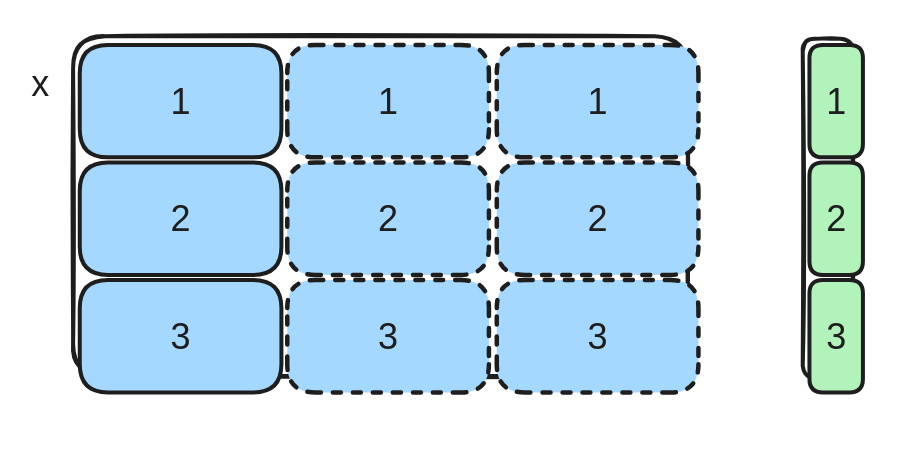

In [12]:
def sum_spec(x: Float32[Tensor, "4 200"]) -> Float32[Tensor, "4"]:
    return x.sum(1)

@triton.jit
def sum_kernel(x_ptr, z_ptr, N0, N1, T, B0: tl.constexpr, B1: tl.constexpr):

    pid = tl.program_id(0)
    offs_0 = pid * B0 + tl.arange(0, B0)

    # YOUR CODE STRATS HERE

    # 1. create an accumulator
    accumulator = tl.zeros([B0], dtype=tl.float32)
    # 2. Iterate to compute a block of the C matrix.
    for i in range(0, tl.cdiv(T, B1)):

        # 3. Create pointers for the blocks of x and load x with mask.
        offs_1 = i * B1 + tl.arange(0, B1)
        mask = offs_1 < T
        offs_x = (offs_0[:, None] * T + offs_1[None, :]).to(tl.int32)
        x_block = tl.load(x_ptr + offs_x, mask=mask[None, :], other=0.0)
        # 4. update accumulator
        accumulator += tl.sum(x_block, axis=1)

    # 5. Write back the block of the output matrix z with masks.
    mask_out = offs_0 < N0
    tl.store(z_ptr + offs_0, accumulator, mask=mask_out)
    # YOUR CODE ENDS HERE

    return

test(sum_kernel, sum_spec, B={"B0": 1, "B1": 32}, nelem={"N0": 4, "N1": 32, "T": 200})


x: jaxtyping.Float32[Tensor, '4 200']
Results match: ✅ True
* Running on public URL: https://78b842c64283cb5cc6.gradio.live


## Question 6 (7 pts): Long Softmax


Softmax of a batch of logits.

Uses one program block axis. Block size `B0` represents the batch of `x` of length `N0`.
Block logit length `T`.   Process it `B1 < T` elements at a time.  

$$z_{i, j} = \text{softmax}(x_{i,1} \ldots x_{i, T}) \text{ for } i = 1\ldots N_0$$

Note softmax needs to be computed in numerically stable form as in Python. In addition in Triton they recommend not using `exp` but instead using `exp2`. You need the identity

$$\exp(x) = 2^{\log_2(e) x}$$

Do it with 2 loops . Hint: you will find this identity useful:

$$\exp(x_i - m) =  \exp(x_i - m/2 - m/2) = \exp(x_i - m/ 2) /  \exp(m/2) $$

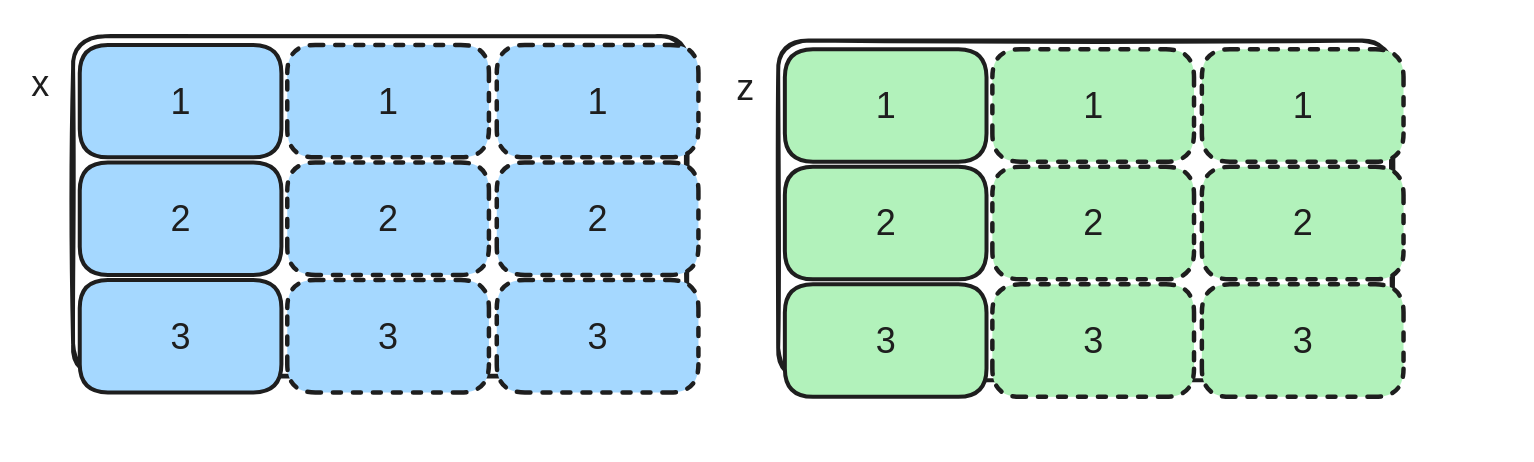

In [13]:
def softmax_spec(x: Float32[Tensor, "4 200"]) -> Float32[Tensor, "4 200"]:
    x_max = x.max(1, keepdim=True)[0]
    x = x - x_max
    x_exp = x.exp()
    return x_exp / x_exp.sum(1, keepdim=True)


# two pass algorithm: https://courses.cs.washington.edu/courses/cse599m/23sp/notes/flashattn.pdf
# first pass, compute max(m) and d
# second pass, compute softmax
@triton.jit
def softmax_kernel(x_ptr, z_ptr, N0, N1, T, B0: tl.constexpr, B1: tl.constexpr):
    pid_0 = tl.program_id(0)
    log2_e = 1.44269504


    # YOUR CODE STRATS HERE

    offsets_x = tl.arange(0, B0) + pid_0 * B0
    mask_x = offsets_x < N0

    # 1. initialize m and d
    m = tl.full([B0], -float("inf"), dtype=tl.float32)
    d = tl.zeros([B0], dtype=tl.float32)

    for i in tl.static_range(0, T, B1):
        offsets_y = tl.arange(0, B1) + i

        mask = (offsets_x[:, None] < N0) & (offsets_y[None, :] < T)
        offsets = offsets_x[:, None] * T + offsets_y[None, :]

        x = tl.load(x_ptr + offsets, mask=mask, other=0.0)

        # 2. compute new_m
        block_max = tl.max(x, axis=1)
        new_m = tl.maximum(m, block_max)

        # 3. use new_m to compute d
        m_diff = m - new_m
        d_scale = tl.exp2(log2_e * m_diff)

        # 4. update m
        x_centered = x - new_m[:, None]
        x_exp = tl.exp2(log2_e * x_centered)
        local_sum = tl.sum(tl.where(mask, x_exp, 0.0), axis=1)
        d = d * d_scale + local_sum
        m = new_m

    for i in tl.static_range(0, T, B1):
        offsets_y = tl.arange(0, B1) + i

        mask = (offsets_x[:, None] < N0) & (offsets_y[None, :] < T)
        offsets = offsets_x[:, None] * T + offsets_y[None, :]

        x = tl.load(x_ptr + offsets, mask=mask, other=0.0)
        # 5. compute z
        x_centered = x - m[:, None]
        num = tl.exp2(log2_e * x_centered)
        z = num / d[:, None]

        tl.store(z_ptr + offsets, z, mask=mask)

        # YOUR CODE ENDS HERE

    return

test(softmax_kernel, softmax_spec, B={"B0": 2, "B1":32},
     nelem={"N0": 4, "N1": 32, "T": 200})

x: jaxtyping.Float32[Tensor, '4 200']
Results match: ✅ True
* Running on public URL: https://fa53bf34ac2cf42c5c.gradio.live


## Question 7 (13 pts): Simple FlashAttention

A scalar version of FlashAttention.

Uses zero programs. Block size `B0` represents `k` of length `N0`.
Block size `B0` represents `q` of length `N0`. Block size `B0` represents `v` of length `N0`.
Sequence length is `T`. Process it `B1 < T` elements at a time.  

$$z_{i} = \sum_{j} \text{softmax}(q_1 k_1, \ldots, q_T k_T)_j v_{j} \text{ for } i = 1\ldots N_0$$

This can be done in 1 loop using a similar trick from the last puzzle.

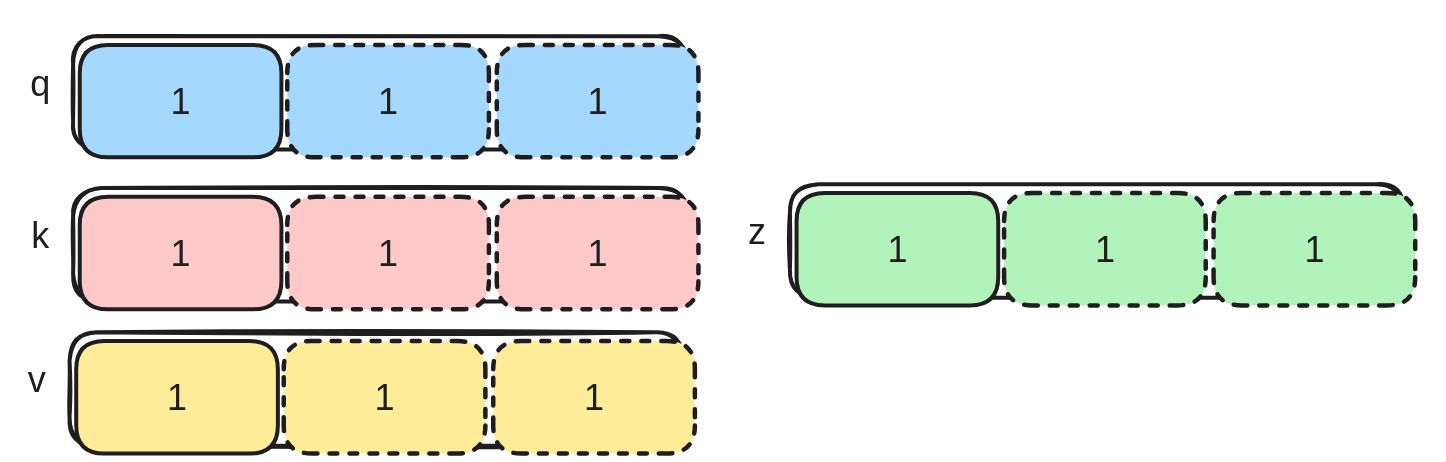

In [14]:
def flashatt_spec(q: Float32[Tensor, "256"], k: Float32[Tensor, "256"], v: Float32[Tensor, "256"]) -> Float32[Tensor, "256"]:
    x = q[:, None] * k[None, :]
    x_max = x.max(1, keepdim=True)[0]
    x = x - x_max
    x_exp = x.exp()
    soft =  x_exp  / x_exp.sum(1, keepdim=True)
    return (v[None, :] * soft).sum(1)

@triton.jit
def flashatt_kernel(q_ptr, k_ptr, v_ptr, z_ptr, N0, T, B0: tl.constexpr):
    pid_0 = tl.program_id(0)
    log2_e = 1.44269504

    # YOUR CODE STRATS HERE
    # 1. initialize m , d and o
    m = tl.full([B0], -float("inf"), dtype=tl.float32)  # max 
    d = tl.zeros([B0], dtype=tl.float32)                # denominator
    o = tl.zeros([B0], dtype=tl.float32)                # output accumulator


    offsets_q = tl.arange(0, B0) + pid_0 * B0
    mask_q = offsets_q < T

    q = tl.load(q_ptr + offsets_q, mask=mask_q, other=0.0)

    for i in tl.static_range(0, T, B0):
        offsets_kv = tl.arange(0, B0) + i
        mask_kv = offsets_kv < T

        k = tl.load(k_ptr + offsets_kv, mask=mask_kv, other=0.0)
        v = tl.load(v_ptr + offsets_kv, mask=mask_kv, other=0.0)

        # 2. compute x
        x = q[:, None] * k[None, :]

        # 3. compute new m,d and o
        x_max = tl.max(x, 1)
        new_m = tl.maximum(m, x_max)
        m_diff = m - new_m
        scale_factor = tl.exp2(log2_e * m_diff)
        x_centered = x - new_m[:, None]
        x_exp = tl.exp2(log2_e * x_centered)
        local_sum = tl.sum(tl.where(mask_kv[None, :], x_exp, 0.0), 1)
        new_d = d * scale_factor + local_sum
        # Update output: o = (o * exp(m - new_m) + sum(v * exp(x - new_m))
        # Compute weighted values
        v_weighted = v[None, :] * x_exp
        v_sum = tl.sum(tl.where(mask_kv[None, :], v_weighted, 0.0), 1)

        new_o = o * scale_factor + v_sum
        # 4. update m,d and o
        m = new_m
        d = new_d
        o = new_o
   
        # YOUR CODE ENDS HERE
    new_o = o / d
    tl.store(z_ptr + offsets_q, new_o, mask=mask_q)

    return

test(flashatt_kernel, flashatt_spec, B={"B0":256},
     nelem={"N0": 256, "T": 256})

q: jaxtyping.Float32[Tensor, '256']
k: jaxtyping.Float32[Tensor, '256']
v: jaxtyping.Float32[Tensor, '256']
Results match: ✅ True


* Running on public URL: https://01d21d104e60e0c686.gradio.live


## Question 8 (15 pts): Quantized Matrix Mult

When doing matrix multiplication with quantized neural networks a common strategy is to store the weight matrix in lower precision, with a shift and scale term.

For this problem our `weight` will be stored in 4 bits. We can store `FPINT` of these in a 32 bit integer. In addition for every `group` weights in order we will store 1 `scale` float value and 1 `shift` 4 bit value. We store these for the column of weight. The `activation`s are stored separately in standard floats.

Mathematically it looks like.

$$z_{j, k} = \sum_{l} sc_{j, \frac{l}{g}} (w_{j, l} - sh_{j, \frac{l}{g}}) \times y_{l, k} \text{ for } i = 1\ldots N_2, j = 1\ldots N_0, k = 1\ldots N_1$$

However, it is a bit more complex since we need to also extract the 4-bit values into floats to begin.




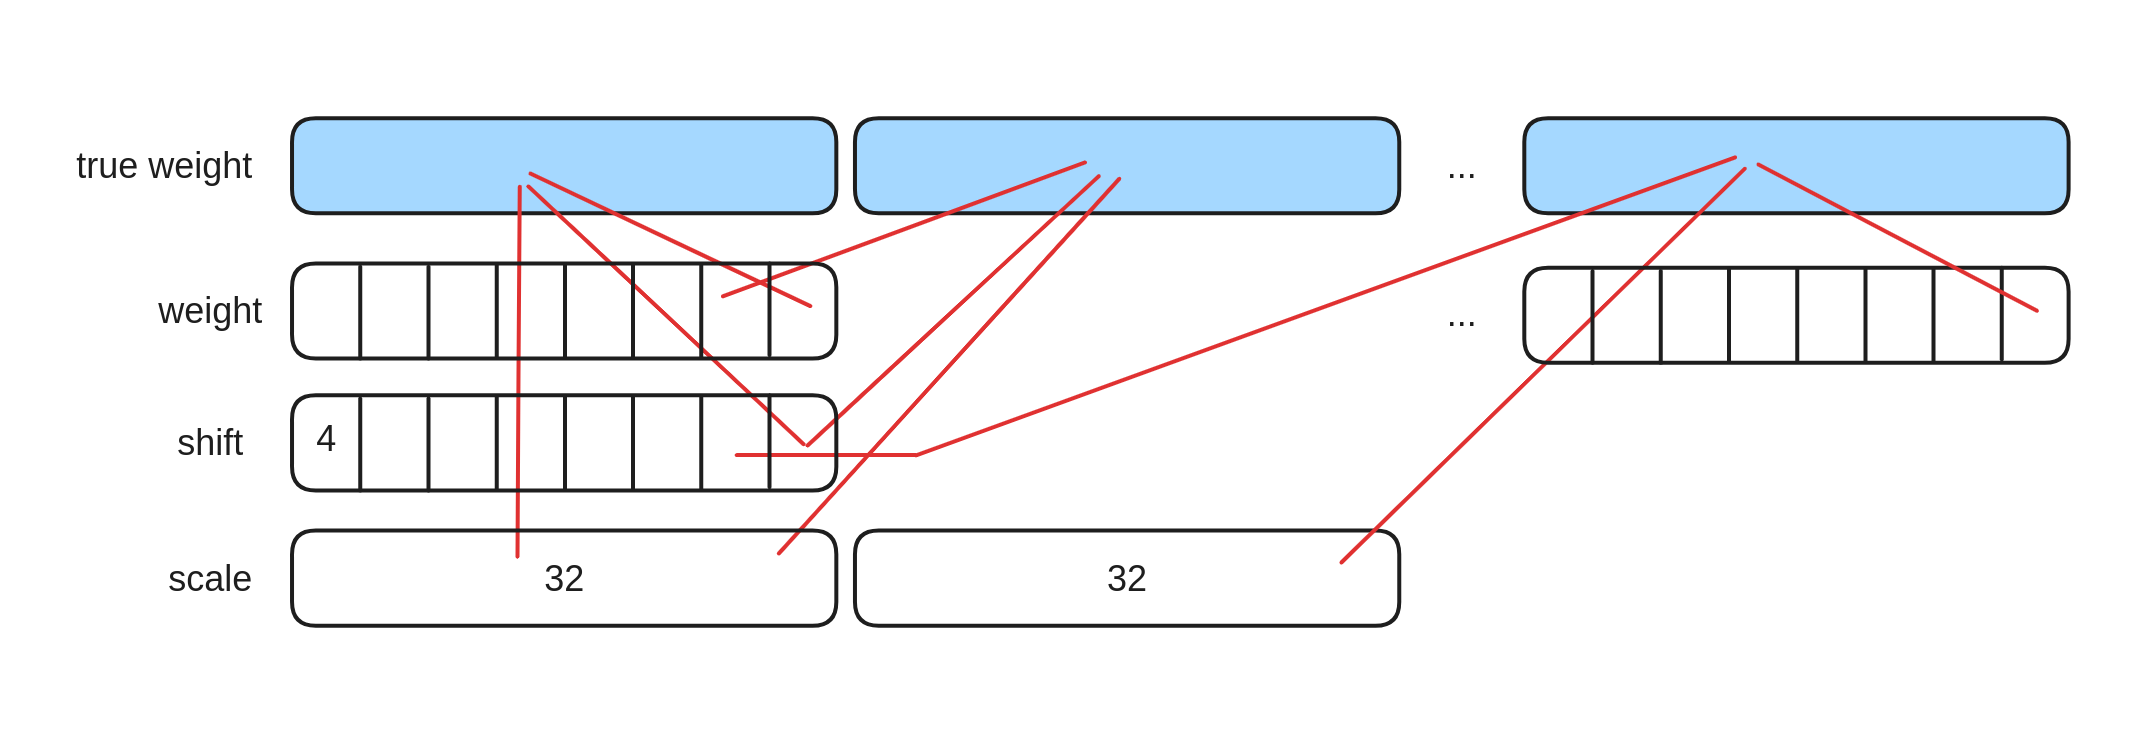

In [15]:

FPINT = 32 // 4
GROUP = 8

def quant_dot_spec(scale : Float32[Tensor, "32 8"],
                   offset : Int32[Tensor, "32"],
                   weight: Int32[Tensor, "32 8"],
                   activation: Float32[Tensor, "64 32"]) -> Float32[Tensor, "32 32"]:
    offset = offset.view(32, 1)
    def extract(x):                             # extract 4 bits values from packed 32 bits int
        over = torch.arange(8) * 4
        mask = 2**4 - 1
        return (x[..., None] >> over) & mask
    scale = scale[..., None].expand(-1, 8, GROUP).contiguous().view(-1, 64)                 
    offset = extract(offset)[..., None].expand(-1, 1, 8, GROUP).contiguous().view(-1, 64)
    return ( scale * (extract(weight).view(-1, 64) - offset))  @ activation

@triton.jit
def quant_dot_kernel(scale_ptr, offset_ptr, weight_ptr, activation_ptr,
                     z_ptr, N0, N1, MID, B0: tl.constexpr, B1: tl.constexpr, B_MID: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)
    #
    row_offset = pid_0 * B0 + tl.arange(0, B0)
    col_offset = pid_1 * B1 + tl.arange(0, B1)
    z = tl.full((B0, B1), value=0.0, dtype=tl.float32)
    # constants for extracting 4-bits from int32
    over = tl.arange(0, 8) * 4
    mask = 2**4 - 1
    for k in tl.static_range(0, MID, B_MID):
        k_offset = tl.arange(k, k+B_MID)
        
        # 1. Create pointers for scale, offset, and weight
        scale_offset_col = k_offset // GROUP
        shift_offset_col = k_offset // GROUP // FPINT
        weight_offset_col = k_offset // FPINT
        
        # 2. Create masks to prevent out-of-bounds accesses
        scale_mask = (scale_offset_col < (MID // GROUP)) & (k_offset < MID)
        shift_mask = shift_offset_col < (MID // GROUP // FPINT)
        weight_mask = weight_offset_col < (MID // FPINT)
        
        # 3. Load scale values (one float per GROUP)
        scale_offset = row_offset[:, None] * (MID // GROUP) + scale_offset_col[None, :]
        scale = tl.load(scale_ptr + scale_offset, mask=scale_mask[None, :], other=0.0)
        
        # 4. Load shift values (packed in 32-bit integers)
        shift_offset = row_offset[:, None] * (MID // GROUP // FPINT) + shift_offset_col[None, :]
        shift = tl.load(offset_ptr + shift_offset, mask=shift_mask[None, :], other=0)
        
        # 5. Extract shift values using bit shifting
        # Calculate which bits to extract for each element
        group_within_int = (k_offset // GROUP) % FPINT
        bit_shift = group_within_int * 4
        
        # 6. Load weight values (packed in 32-bit integers)
        weight_offset = row_offset[:, None] * (MID // FPINT) + weight_offset_col[None, :]
        weight = tl.load(weight_ptr + weight_offset, mask=weight_mask[None, :], other=0)
        
        # 7. Extract weight values using bit shifting
        bit_pos = (k_offset % FPINT) * 4
        weight_val = ((weight >> bit_pos[None, :]) & mask).to(tl.float32)
        
        # 8. Extract shift values
        shift_val = ((shift >> bit_shift[None, :]) & mask).to(tl.float32)
        
        # 9. Apply scale * (weight - shift)
        dequantized = scale * (weight_val - shift_val)
        
        # 10. Load activations
        activation_mask = (k_offset[:, None] < MID) & (col_offset[None, :] < N1)
        activation_offset = k_offset[:, None]*N1 + col_offset[None, :]
        activation = tl.load(activation_ptr + activation_offset, mask=activation_mask, other=0.0)
        
        # 11. Matrix multiplication
        z += tl.dot(dequantized, activation)
    
    # Store the result
    z_mask = (row_offset[:, None] < N0) & (col_offset[None, :] < N1)
    z_offset = row_offset[:, None] * N1 + col_offset[None, :]
    tl.store(z_ptr + z_offset, z, mask=z_mask)


test(quant_dot_kernel, quant_dot_spec, B={"B0": 16, "B1": 16, "B_MID": 64},
                                       nelem={"N0": 32, "N1": 32, "MID": 64})


scale: jaxtyping.Float32[Tensor, '32 8']
offset: jaxtyping.Int32[Tensor, '32']
weight: jaxtyping.Int32[Tensor, '32 8']
activation: jaxtyping.Float32[Tensor, '64 32']
Results match: ✅ True
* Running on public URL: https://02ddac1fedac003ad3.gradio.live
